In [291]:
import pandas as pds
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from pandasql import sqldf
import functools

## define function for printing pandas dataframes as markdown

In [292]:
def print_pandas_md(df):
    print(tabulate(df, tablefmt="pipe", headers="keys"))

## define function to round values in an interval object

In [293]:
def round_interval(interval):
    left_val = round(interval.left)
    right_val = round(interval.right)
    return pds.Interval(left=left_val, right=right_val, closed='left')

## load local copies of data

In [294]:
patient_df = pds.read_csv('triplestore-patient-info.tsv', sep='\t')

In [335]:
tooth_proc_df = pds.read_csv('triplestore-tooth-procedure-info.tsv', sep='\t')

In [336]:
tooth_type_df = pds.read_csv('triplestore-tooth-type-info.tsv', sep='\t')

In [337]:
proc_surface_df = pds.read_csv('triplestore-procedure-surface-info.tsv', sep='\t')

In [338]:
proc_material_df = pds.read_csv('triplestore-proc-material-info.tsv', sep='\t')

# Plot data

## plot total number of distinct teeth by tooth type that underwent a procedure

### calculate the number of each tooth type

In [339]:
tooth_df = tooth_proc_df[['patient_id', 'tooth_num']].copy()
tooth_df.tooth_num = tooth_df.tooth_num.astype(int)
tooth_count_query = """
select 
    tooth_num, count(*) as num_teeth
from
    tooth_df
group by
    tooth_num
order by
    tooth_num
"""
tooth_count_df = sqldf(tooth_count_query)

In [340]:
# tooth_count_df.head()

### plot

/Users/widuncan/repos/git/NDPBRN/src/analysis/.env/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/Users/widuncan/repos/git/NDPBRN/src/analysis/.env/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


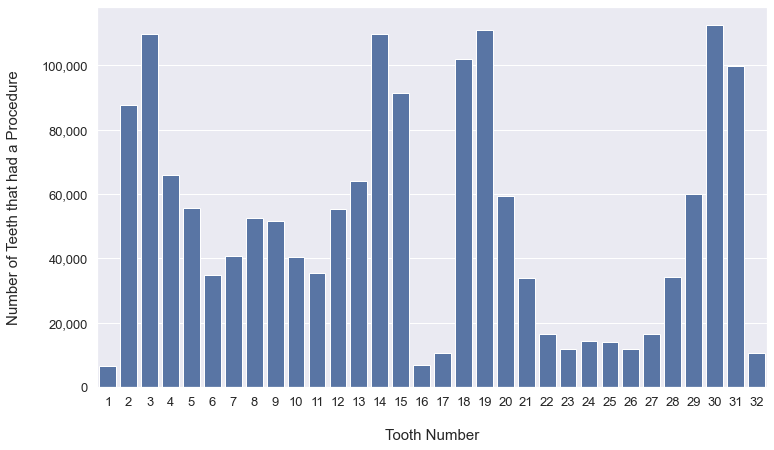

In [341]:
%matplotlib inline

plt.figure(figsize=(12,7))
ax = sns.barplot(x='tooth_num', y='num_teeth',data=tooth_count_df, color='#4c72b0')

ax.set_xlabel("\nTooth Number", fontsize=15)
ax.set_ylabel("Number of Teeth that had a Procedure\n", fontsize=15)

tooth_nums = [x for x in range(1,33)] # create list of tooth nums
ax.set_xticklabels(tooth_nums, size=13)
ax.set_yticklabels(ax.get_yticks(), size=13)

ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]) # put commas in y-ticks
# plt.savefig("figures/tooth-count-per-tooth.png", dpi=600, bbox_inches="tight")
plt.show()

## plot total number of distinct teeth by tooth type that underwent a procedure by gender

### join tooth information to gender information

In [342]:
tooth_gender_query = """
select
    tooth_df.patient_id, tooth_num, gender
from
    tooth_df
inner join
    patient_df
on
    tooth_df.patient_id = patient_df.patient_id
order by
    tooth_num
"""
tooth_gender_df = sqldf(tooth_gender_query)

### calculate the number of teeth for each tooth type and gender

In [343]:
tooth_gender_count_query = """
select 
    tooth_num, gender, count(*) as num_teeth
from
    tooth_gender_df
group by
    tooth_num, gender
order by
    tooth_num
"""
tooth_gender_count_df = sqldf(tooth_gender_count_query)

In [344]:
# tooth_gender_count_df.head()

### plot

/Users/widuncan/repos/git/NDPBRN/src/analysis/.env/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/Users/widuncan/repos/git/NDPBRN/src/analysis/.env/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


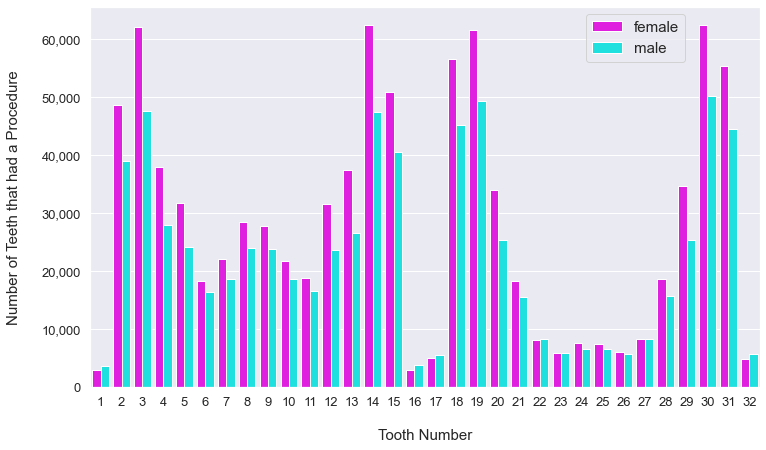

In [345]:
%matplotlib inline
colors = ['magenta', 'cyan']
sns.set_palette(colors)
# sns.set(font_scale=1)

plt.figure(figsize=(12,7))
ax = sns.barplot(x='tooth_num', y='num_teeth', hue="gender",data=tooth_gender_count_df)

ax.set_xlabel("\nTooth Number", fontsize=15)
ax.set_ylabel("Number of Teeth that had a Procedure\n", fontsize=15)

tooth_nums = [x for x in range(1,33)] # create list of tooth nums
ax.set_xticklabels(tooth_nums, size=13)
ax.set_yticklabels(ax.get_yticks(), size=13)
ax.legend(loc='upper right', fontsize=15, bbox_to_anchor=(0.9, 1))

ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]) # put commas in y-ticks
plt.savefig("figures/tooth-count-per-tooth-by-gender.png", dpi=600, bbox_inches="tight")
plt.show()

## create table with tooth number totals for females, males, and all (i.e., males and females)
### this table is helpful for error checking and putting in to paper

In [346]:
## this looks a little hairy, but it only a merger of two queries
## followed by the subset of data we want
## followed by renaming the columns output by the merge
gender_count_table = \
    pds.merge(tooth_gender_count_df.query("gender == 'female'"),
    tooth_gender_count_df.query("gender == 'male'"),
    how='inner',
    on='tooth_num')[['tooth_num', 'num_teeth_x', 'num_teeth_y']].rename(columns={'num_teeth_x': 'female', 'num_teeth_y': 'male'})

In [347]:
# gender_count_table.head()

In [348]:
## merge gender counts with the totals of all teet
all_tooth_count_table = \
    pds.merge(gender_count_table, tooth_count_df, how='inner', on='tooth_num').rename(columns={'num_teeth': 'total'})

In [349]:
all_tooth_count_table.head()

,tooth_num,female,male,total
0,1,2956,3623,6579
1,2,48644,38915,87559
2,3,62118,47690,109808
3,4,37956,27955,65911
4,5,31684,24125,55809
